
# Sequence Models and Long Short-Term Memory Networks

This section from https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

Written by Robert Guthrie

At this point, we have seen various feed-forward networks. That is,
there is no state maintained by the network at all. This might not be
the behavior we want. Sequence models are central to NLP: they are
models where there is some sort of dependence through time between your
inputs. The classical example of a sequence model is the Hidden Markov
Model for part-of-speech tagging. Another example is the conditional
random field.

A recurrent neural network is a network that maintains some kind of
state. For example, its output could be used as part of the next input,
so that information can propagate along as the network passes over the
sequence. In the case of an LSTM, for each element in the sequence,
there is a corresponding *hidden state* $h_t$, which in principle
can contain information from arbitrary points earlier in the sequence.
We can use the hidden state to predict words in a language model,
part-of-speech tags, and a myriad of other things.


## LSTMs in Pytorch

Before getting to the example, note a few things. Pytorch's LSTM expects
all of its inputs to be 3D tensors. The semantics of the axes of these
tensors is important. The first axis is the sequence itself, the second
indexes instances in the mini-batch, and the third indexes elements of
the input. We haven't discussed mini-batching, so let's just ignore that
and assume we will always have just 1 dimension on the second axis. If
we want to run the sequence model over the sentence "The cow jumped",
our input should look like

\begin{align}\begin{bmatrix}
   \overbrace{q_\text{The}}^\text{row vector} \\
   q_\text{cow} \\
   q_\text{jumped}
   \end{bmatrix}\end{align}

Except remember there is an additional 2nd dimension with size 1.

In addition, you could go through the sequence one at a time, in which
case the 1st axis will have size 1 also.

Let's see a quick example.


In [10]:
# Author: Robert Guthrie

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

np.random.seed(1)
torch.manual_seed(1)

In [2]:
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# initialize the hidden state.
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)

# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

tensor([[[-0.0187,  0.1713, -0.2944]],

        [[-0.3521,  0.1026, -0.2971]],

        [[-0.3191,  0.0781, -0.1957]],

        [[-0.1634,  0.0941, -0.1637]],

        [[-0.3368,  0.0959, -0.0538]]], grad_fn=<StackBackward0>)
(tensor([[[-0.3368,  0.0959, -0.0538]]], grad_fn=<StackBackward0>), tensor([[[-0.9825,  0.4715, -0.0633]]], grad_fn=<StackBackward0>))


## Example: An LSTM for Part-of-Speech Tagging

In this section, we will use an LSTM to get part of speech tags. We will
not use Viterbi or Forward-Backward or anything like that, but as a
(challenging) exercise to the reader, think about how Viterbi could be
used after you have seen what is going on. In this example, we also refer
to embeddings. If you are unfamiliar with embeddings, you can read up 
about them [here](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html)_.

The model is as follows: let our input sentence be
$w_1, \dots, w_M$, where $w_i \in V$, our vocab. Also, let
$T$ be our tag set, and $y_i$ the tag of word $w_i$.
Denote our prediction of the tag of word $w_i$ by
$\hat{y}_i$.

This is a structure prediction, model, where our output is a sequence
$\hat{y}_1, \dots, \hat{y}_M$, where $\hat{y}_i \in T$.

To do the prediction, pass an LSTM over the sentence. Denote the hidden
state at timestep $i$ as $h_i$. Also, assign each tag a
unique index (like how we had word\_to\_ix in the word embeddings
section). Then our prediction rule for $\hat{y}_i$ is

\begin{align}\hat{y}_i = \text{argmax}_j \  (\log \text{Softmax}(Ah_i + b))_j\end{align}

That is, take the log softmax of the affine map of the hidden state,
and the predicted tag is the tag that has the maximum value in this
vector. Note this implies immediately that the dimensionality of the
target space of $A$ is $|T|$.


Prepare data:



In [7]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner 
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}
# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index

ix_to_word = {v: k for k, v in word_to_ix.items()}
print(word_to_ix)
print(ix_to_word)

tag_to_ix = {"DET": 0, "NN": 1, "V": 2}  # Assign each tag with a unique index
ix_to_tag = {v: k for k, v in tag_to_ix.items()}
# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}
{0: 'The', 1: 'dog', 2: 'ate', 3: 'the', 4: 'apple', 5: 'Everybody', 6: 'read', 7: 'that', 8: 'book'}


Create the model:



In [4]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

Train the model:



In [14]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    test_sentence = "the book ate the apple".split()
    inputs = prepare_sequence(test_sentence, word_to_ix)
    tag_scores = model(inputs)
    best_tag = np.argmax(tag_scores.cpu().numpy(), axis=1)
    for i in range(best_tag.shape[0]):
        print("{:6s} {:3s}".format(
            test_sentence[i],
            ix_to_tag[best_tag[i]])
        )
    # print(tag_scores)

for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    best_tag = np.argmax(tag_scores.cpu().numpy(), axis=1)
    for i in range(best_tag.shape[0]):
        print("{:6s} {:3s}".format(
            test_sentence[i],
            ix_to_tag[best_tag[i]])
        )

the    NN 
book   NN 
ate    NN 
the    NN 
apple  NN 
the    DET
book   NN 
ate    V  
the    DET
apple  NN 


In [15]:
# If using local runtime
base_dir = "~/Documents"
# If using hosted runtime
# base_dir = "/content"

# helper code from the course repository
!cd $base_dir && git clone -q https://github.com/zachwooddoughty/cs449w23.git
# install common pacakges used for deep learning
!cd $base_dir/cs449w23/ && pip install -q -r requirements.txt

# make sure we're in the right directory
%cd $base_dir/cs449w23/
!git pull -q origin main

fatal: destination path 'cs449w23' already exists and is not an empty directory.
/Users/zachwooddoughty/Documents/cs449w23


# Learning to sum a sequence

Let's train an LSTM to learn to sum the elements of a sequence.

In [16]:
%matplotlib inline

import datetime
import itertools
import math
import time
import torch
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from matplotlib.animation import FuncAnimation
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm import tqdm

First, let's generate a simple sequence.

In [17]:
def generate_sequence(length=10, num_prob=0.5):
    is_number = np.random.rand(length) < num_prob
    numbers = np.random.randint(-100, 100, size=length)
    return np.where(is_number, numbers, 0)

def build_dataset(n, length=10, num_prob=0.5):
    X = [generate_sequence(length, num_prob) for _ in range(n)]
    X = np.stack(X, axis=0).reshape(length, n, 1)
    X = torch.tensor(X).float()
    y = torch.tensor(np.nansum(X, axis=0)).float()

    return (X, y)


X, y = build_dataset(3, length=10, num_prob=0.5)
print(X)
print(y)

tensor([[[  1.],
         [  0.],
         [ 39.]],

        [[ 56.],
         [ 57.],
         [ 42.]],

        [[-50.],
         [-32.],
         [ -4.]],

        [[  0.],
         [  0.],
         [  0.]],

        [[ 31.],
         [  0.],
         [  0.]],

        [[  0.],
         [-43.],
         [-97.]],

        [[ 96.],
         [  0.],
         [  4.]],

        [[  0.],
         [  0.],
         [ 95.]],

        [[  0.],
         [  0.],
         [  0.]],

        [[  0.],
         [  0.],
         [ 65.]]])
tensor([[134.],
        [-18.],
        [144.]])


Our model is just an LSTM that passes its final hidden state through a linear to make a regression prediction.

In [18]:
# https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
class LSTMRegression(torch.nn.Module):
    def __init__(self, input_dim=1, hidden_dim=8, output_dim=1):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim)
        self.linear = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, X):
        hidden, (c, h) = self.lstm(X)
        return self.linear(hidden[-1, :])

Set up our model to train. Note that this is extremely inefficient because we aren't batching, but batching sequences is a little bit of a pain.

In [19]:
def train_model(model, opt, X, y, n_epochs, verbose=True):
    start = time.time()
    for epoch in range(n_epochs):
        n_train = X.shape[1]
        model.zero_grad()
        epoch_loss = 0
        for i in range(n_train):
            pred = model(X[:, i, :])
            epoch_loss += mse_loss(pred, y[i,])
        epoch_loss.backward()
        opt.step()

        epoch_loss /= n_train
        if verbose:
            if epoch == 0 or (epoch + 1) % max(1, n_epochs // 10) == 0:
                minutes = (time.time() - start) / 60
                
                log = "  ".join([
                    f"Epoch: {epoch + 1:3d}",
                    f"in {minutes:4.1f} min",
                    f"Loss: {epoch_loss:10.1f}",
                ])
                print(log)

        if epoch_loss < 1:
            print(f"Done after {epoch} epochs")
            break
    return epoch_loss

Train (with a bit of a grid search over hyperparameters) our model
to sum up to 16 numbers.

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMRegression(input_dim=1, hidden_dim=64, output_dim=1).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.1)

mse_loss = torch.nn.MSELoss()

X, y = build_dataset(n=1000, length=2, num_prob=1)
X = X.to(device)
y = y.to(device)

_ = train_model(model, opt, X, y, n_epochs=100)

# length 2
# n 1000
# hidden_dim 8
  # lr 1.0   -> Epoch: 100  in  1.5 min  Loss:      932.8
  # lr 1.0   -> Epoch: 200  in  2.9 min  Loss:      907.2
  # lr 0.5   -> Epoch: 100  in  1.4 min  Loss:     1189.0
  # lr 0.5   -> Epoch: 200  in  2.9 min  Loss:      473.4
  # lr 0.1   -> Epoch: 100  in  1.4 min  Loss:     4353.9
  # lr 0.01  -> Epoch: 100  in  1.4 min  Loss:     8990.8
# hidden_dim 32
  # lr 0.5   -> Epoch: 200  in  2.7 min  Loss:       58.2
# hidden_dim 64
  # lr 0.5   -> Epoch: 200  in  2.8 min  Loss:       32.6
  # lr 0.1   -> Epoch: 200  in  3.0 min  Loss:        7.4

# length 4
# hidden_dim 64
  # lr 0.1   -> Epoch: 200  in  2.9 min  Loss:       37.3

# length 8
# hidden_dim 64
  # lr 0.1   -> Epoch: 200  in  3.0 min  Loss:      196.7

# length 8
# n 10000
# hidden_dim 64
  # lr 0.1   -> Epoch:  20  in  3.0 min  Loss:    13358.0
  # lr 0.5   -> Epoch:  20  in  3.0 min  Loss:     5662.8
  # lr 0.5   -> Epoch:  40  in  6.0 min  Loss:     2308.6

# length 16
# hidden_dim 64
# n 1000
  # lr 0.1   -> Epoch:  40  in  0.6 min  Loss:    12399.2
  # lr 1.0   -> Epoch:  40  in  0.6 min  Loss:    13372.9
# n 2000
  # lr 0.5   -> Epoch:  40  in  1.4 min  Loss:    10271.7
# n 10000
  # lr 0.1   -> Epoch:  20  in  3.3 min  Loss:    35480.2
  # lr 0.1   -> Epoch:  40  in  6.5 min  Loss:    17018.8
  # lr 0.1   -> Epoch: 100  in 15.9 min  Loss:     5027.0
  # lr 0.5   -> Epoch:  40  in  6.4 min  Loss:    13417.8
  # lr 0.5   -> Epoch: 100  in 16.0 min  Loss:     8280.9

Epoch:   1  in  0.0 min  Loss:     7087.4
Epoch:  10  in  0.2 min  Loss:     4929.0
Epoch:  20  in  0.3 min  Loss:     2181.5
Epoch:  30  in  0.4 min  Loss:      833.7
Epoch:  40  in  0.6 min  Loss:      333.8
Epoch:  50  in  0.8 min  Loss:      166.6
Epoch:  60  in  0.9 min  Loss:       91.1
Epoch:  70  in  1.1 min  Loss:       62.0
Epoch:  80  in  1.3 min  Loss:       43.1
Epoch:  90  in  1.5 min  Loss:       31.1
Epoch: 100  in  1.6 min  Loss:       22.4


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model16 = LSTMRegression(input_dim=1, hidden_dim=64, output_dim=1).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.1)

mse_loss = torch.nn.MSELoss()

X, y = build_dataset(n=1000, length=8, num_prob=1)
X = X.to(device)
y = y.to(device)

_ = train_model(model16, opt, X, y, n_epochs=10)

Epoch:   1  in  0.0 min  Loss:    27747.7
Epoch:   2  in  0.1 min  Loss:    27747.7
Epoch:   3  in  0.1 min  Loss:    27747.7
Epoch:   4  in  0.2 min  Loss:    27747.7
Epoch:   5  in  0.2 min  Loss:    27747.7
Epoch:   6  in  0.2 min  Loss:    27747.7
Epoch:   7  in  0.3 min  Loss:    27747.7
Epoch:   8  in  0.3 min  Loss:    27747.7
Epoch:   9  in  0.4 min  Loss:    27747.7
Epoch:  10  in  0.4 min  Loss:    27747.7


In [25]:
print("len     mean      std")
lengths = [2, 4, 8, 16]
n_test = 100
for length_idx, length in enumerate(lengths):
    results = []
    X_test, y_test = build_dataset(n=n_test, length=length, num_prob=1)
    for example_idx in range(n_test):
        example = X_test[:, example_idx, :].to(device)
        pred = model(example)
        target = y_test[example_idx,].numpy()
        pred = pred.cpu().detach().numpy().round(3)[0]
        results.append((target - pred) ** 2)
    mean_mse = np.mean(results)
    std_mse = np.std(results)
    print(f"{length:3d} {mean_mse:>8.1f} {std_mse:>8.1f}")

len     mean      std
  2   5342.9   5911.5
  4  14519.9  17159.9
  8  27506.9  35581.5
 16  51115.8  71984.2


Len   2; loss:     23.4
Len   4; loss:     19.8
Len   8; loss:    669.6
Len  16; loss:  10030.5
Len  32; loss:  31859.4
Len  64; loss: 110603.9
Len 128; loss: 272113.2
Len 256; loss: 428645.0


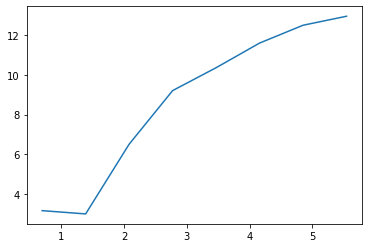

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = LSTMRegression(input_dim=1, hidden_dim=64, output_dim=1).to(device)
opt = torch.optim.Adam(model2.parameters(), lr=0.1)

mse_loss = torch.nn.MSELoss()

lengths = [2, 4, 8, 16, 32, 64, 128, 256]
losses = []
for length in lengths:
    X, y = build_dataset(n=100, length=length, num_prob=1)
    X = X.to(device)
    y = y.to(device)

    final_loss = train_model(model2, opt, X, y, n_epochs=100, verbose=False)
    final_loss = final_loss.detach().cpu().numpy()
    losses.append(final_loss)
    print(f"Len {length:3d}; loss: {final_loss:8.1f}")

axis = plt.subplot()
axis.plot(np.log(np.array(lengths)), np.log(np.array(losses)))
plt.show()